Saving tcr.xlsx to tcr (3).xlsx

✅ Loaded dataset: tcr (3).xlsx
Shape: (7043, 23)

🔢 Numeric Features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'numAdminTickets', 'numTechTickets']
🔤 Categorical Features: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

📊 Final Model Performance
Accuracy   : 0.8465
Precision  : 0.7026
Recall     : 0.7326
F1 Score   : 0.7173
ROC AUC    : 0.9206

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.90      0.89      0.89      1033
       Churn       0.70      0.73      0.72       374

    accuracy                           0.85      1407
   macro avg       0.80      0.81      0.81      1407
weighted avg       0.85      0.85      0.85      1407



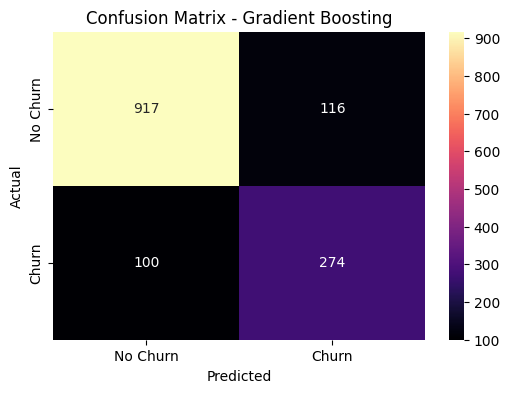

/tmp/ipython-input-2985872482.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=top_features, palette="Spectral")


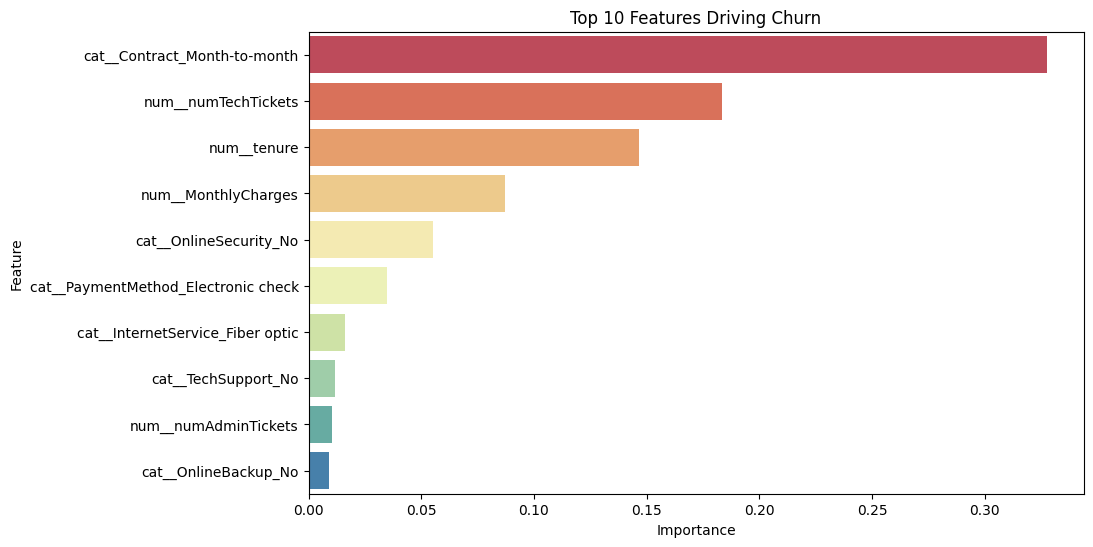


🔥 Top 10 features driving churn:
1. cat__Contract_Month-to-month
2. num__numTechTickets
3. num__tenure
4. num__MonthlyCharges
5. cat__OnlineSecurity_No
6. cat__PaymentMethod_Electronic check
7. cat__InternetService_Fiber optic
8. cat__TechSupport_No
9. num__numAdminTickets
10. cat__OnlineBackup_No


In [11]:
# ================= Imports =================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score
)
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from google.colab import files

# ================= File Upload =================
uploaded = files.upload()

# Detect uploaded file name
file_name = list(uploaded.keys())[0]

# Read data automatically depending on extension
if file_name.endswith(".csv"):
    df = pd.read_csv(file_name)
elif file_name.endswith(".xlsx"):
    df = pd.read_excel(file_name)
else:
    raise ValueError("Unsupported file format. Please upload .csv or .xlsx")

print(f"\n✅ Loaded dataset: {file_name}")
print("Shape:", df.shape)

# ================= Data Cleaning =================
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df = df.dropna(subset=["TotalCharges"])  # drop missing

# Target variable
y = df["Churn"].map({"Yes": 1, "No": 0})
X = df.drop(columns=["Churn", "customerID", "TotalCharges"])

# Features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

print("\n🔢 Numeric Features:", numeric_features)
print("🔤 Categorical Features:", categorical_features)

# ================= Preprocessing =================
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# ================= Model with SMOTE =================
smote_pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", GradientBoostingClassifier(
        n_estimators=400,       # more trees
        learning_rate=0.05,     # slower learning
        max_depth=6,            # deeper trees
        random_state=42
    ))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Fit model
smote_pipeline.fit(X_train, y_train)

# ================= Evaluation =================
y_pred = smote_pipeline.predict(X_test)
y_proba = smote_pipeline.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("\n📊 Final Model Performance")
print(f"Accuracy   : {acc:.4f}")
print(f"Precision  : {prec:.4f}")
print(f"Recall     : {rec:.4f}")
print(f"F1 Score   : {f1:.4f}")
print(f"ROC AUC    : {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["No Churn", "Churn"]))

# ================= Confusion Matrix =================
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="magma",
            xticklabels=["No Churn", "Churn"],
            yticklabels=["No Churn", "Churn"])
plt.title("Confusion Matrix - Gradient Boosting")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ================= Feature Importance =================
preprocessor = smote_pipeline.named_steps["preprocessor"]
gb_model = smote_pipeline.named_steps["classifier"]

# Numeric + categorical names
feature_names = preprocessor.get_feature_names_out()

feature_importances = pd.DataFrame({
    "feature": feature_names,
    "importance": gb_model.feature_importances_
})

top_features = feature_importances.sort_values(
    by="importance", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=top_features, palette="Spectral")
plt.title("Top 10 Features Driving Churn")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

print("\n🔥 Top 10 features driving churn:")
for i, feature in enumerate(top_features["feature"], 1):
    print(f"{i}. {feature}")
